#### grounding dino

In [1]:
from groundingdino.util.inference import Model


CONFIG_PATH = "GroundingDINO_SwinT_OGC.py"
WEIGHTS_PATH = "groundingdino_swint_ogc.pth"

model = Model(model_config_path=CONFIG_PATH, model_checkpoint_path=WEIGHTS_PATH)

CLASSES = ['window']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

c:\Users\mohamad\AppData\Local\Programs\Python\Python310\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\mohamad\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [2]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections
import matplotlib.pyplot as plt


@dataclass_json
@dataclass
class COCOCategory:
    id: int
    name: str
    supercategory: str


@dataclass_json
@dataclass
class COCOImage:
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
    coco_url: Optional[str] = None
    flickr_url: Optional[str] = None


@dataclass_json
@dataclass
class COCOAnnotation:
    id: int
    image_id: int
    category_id: int
    segmentation: List[List[float]]
    area: float
    bbox: Tuple[float, float, float, float]
    iscrowd: int


@dataclass_json
@dataclass
class COCOLicense:
    id: int
    name: str
    url: str


@dataclass_json
@dataclass
class COCOJson:
    images: List[COCOImage]
    annotations: List[COCOAnnotation]
    categories: List[COCOCategory]
    licenses: Optional[List[COCOLicense]] = None


def load_coco_json(json_file: str) -> COCOJson:
    import json

    with open(json_file, "r") as f:
        json_data = json.load(f)

    return COCOJson.from_dict(json_data, infer_missing=True)


class COCOJsonUtility:
    @staticmethod
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]

    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data, image.id)
        else:
            return None

    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None

    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])

        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array(class_id, dtype=int)
        )

In [3]:
import os

IMAGES_DIRECTORY_PATH = "Evaluation_dataset"
ANNOTATIONS_FILE_PATH = os.path.join(IMAGES_DIRECTORY_PATH, "merged.json")

# IMAGES_DIRECTORY_PATH = os.path.join("chocolate-candy-3", "test")
# ANNOTATIONS_FILE_PATH = os.path.join(IMAGES_DIRECTORY_PATH, "_annotations.coco.json")

In [4]:
coco_data = load_coco_json(json_file=ANNOTATIONS_FILE_PATH)

CLASSES = [
    category.name
    for category
    in coco_data.categories
    if category.supercategory != 'none'
]

IMAGES = [
    image.file_name
    for image
    in coco_data.images
]

c:\Users\mohamad\AppData\Local\Programs\Python\Python310\lib\site-packages\dataclasses_json\core.py:194: RuntimeWarning: Missing value of non-optional type license detected when decoding COCOImage and was defaulted to None by infer_missing=True. Set infer_missing=False (the default) to prevent this behavior.
  warnings.warn(
c:\Users\mohamad\AppData\Local\Programs\Python\Python310\lib\site-packages\dataclasses_json\core.py:194: RuntimeWarning: Missing value of non-optional type date_captured detected when decoding COCOImage and was defaulted to None by infer_missing=True. Set infer_missing=False (the default) to prevent this behavior.
  warnings.warn(
c:\Users\mohamad\AppData\Local\Programs\Python\Python310\lib\site-packages\dataclasses_json\core.py:194: RuntimeWarning: Missing value of non-optional type supercategory detected when decoding COCOCategory and was defaulted to None by infer_missing=True. Set infer_missing=False (the default) to prevent this behavior.
  warnings.warn(


In [5]:
from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

In [6]:
import random
random.seed(10)

In [7]:
import cv2

import supervision as sv

detections.class_id [0 0 0 0 0 0 0 0 0 0 0]


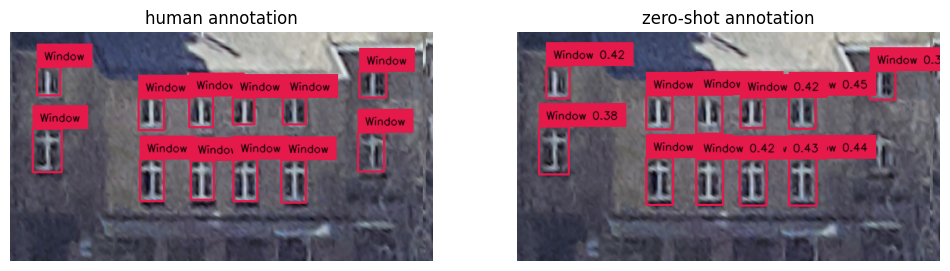

In [9]:
EXAMPLE_IMAGE_NAME = random.choice(IMAGES)
EXAMPLE_IMAGE_PATH = os.path.join(IMAGES_DIRECTORY_PATH, EXAMPLE_IMAGE_NAME)

# load dataset annotations and image
annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=EXAMPLE_IMAGE_NAME)
ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)

# small hack - coco numerate classes from 1, model from 0 + we drop first redundant class from coco json
ground_truth.class_id = ground_truth.class_id - 1

image = cv2.imread(EXAMPLE_IMAGE_PATH)
h, w, _ = image.shape

# initiate annotator
box_annotator = sv.BoxAnnotator()

# annotate image with ground truth
labels = [
    f"{CLASSES[class_id]}" 
    for _, _, _, class_id, _  # Adjusted to match the 5-element structure 
    in ground_truth]
annotated_frame_ground_truth = box_annotator.annotate(
    scene=image.copy(), detections=ground_truth, labels=labels)

# run model and annotate image with detections
detections = model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# Replace None in class_id with 0 for NumPy arrays
detections.class_id = np.where(detections.class_id == None, 0, detections.class_id)


print("detections.class_id", detections.class_id)

# drop potential detections with phrase that is not part of CLASSES set
# detections = detections[detections.class_id != None]
# drop potential detections with area close to area of whole image
detections = detections[(detections.area / (h * w)) < 0.9 ]
# drop potential double detections
detections = detections.with_nms()
    
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _ in detections
    if class_id is not None  # Only include detections with valid class IDs
]
annotated_frame = box_annotator.annotate(
    scene=image.copy(), detections=detections, labels=labels)


%matplotlib inline
sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_frame],
    grid_size=(1, 2),
    titles=["human annotation", "zero-shot annotation"]
)

In [10]:
from tqdm.notebook import tqdm

ground_true_batches, detections_batches = [], []
for image in tqdm(coco_data.images):
    image_name = image.file_name
    image_path = os.path.join(IMAGES_DIRECTORY_PATH, image_name)
    annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=image_name)
    try:
        ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)
    except:
        ground_truth = Detections(
            xyxy=np.empty((0, 4), dtype=np.float32),
            confidence=np.array([], dtype=np.float32),
            class_id=np.array([], dtype=int)
        )

    # small hack - coco numerate classes from 1, model from 0
    ground_truth.class_id = ground_truth.class_id - 1

    ground_true_batch = np.column_stack((
        ground_truth.xyxy, 
        ground_truth.class_id
    ))
    image = cv2.imread(image_path)
    detections = model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )

    # Replace None in class_id with 0 for NumPy arrays
    detections.class_id = np.where(detections.class_id == None, 0, detections.class_id)

    # drop potential detections with phrase that is not part of CLASSES set
    # detections = detections[detections.class_id != None]
    # drop potential detections with area close to area of whole image
    detections = detections[(detections.area / (h * w)) < 0.9 ]
    # drop potential double detections
    detections = detections.with_nms()

    detections_batch = np.column_stack((
        detections.xyxy, 
        detections.class_id,
        detections.confidence
    ))
    ground_true_batches.append(ground_true_batch)
    detections_batches.append(detections_batch)

  0%|          | 0/477 [00:00<?, ?it/s]

In [ ]:
print("ground_true_batches", ground_true_batches)
print("detections_batches", detections_batches)

ground_true_batches [array([[ 94,   0, 131,  54,   0],
       [156,  73, 195, 143,   0]]), array([[ 54,  28,  88, 107,   0],
       [111,  30, 144, 108,   0],
       [ 54, 125,  89, 206,   0],
       [111, 128, 145, 206,   0],
       [193,  40, 213,  60,   0],
       [226,  40, 245,  60,   0],
       [257,  40, 278,  60,   0],
       [193, 138, 213, 157,   0],
       [226, 138, 244, 157,   0],
       [256, 138, 275, 155,   0]]), array([[ 213,   17,  240,   85,    0],
       [ 317,   16,  347,   83,    0],
       [  34,  159,   58,  189,    0],
       [  81,  159,  103,  187,    0],
       [  33,  248,   59,  276,    0],
       [ 477,    0,  504,   47,    0],
       [ 427,  161,  453,  230,    0],
       [ 427,  247,  453,  302,    0],
       [ 504,  164,  531,  230,    0],
       [ 505,  247,  531,  303,    0],
       [ 539,    0,  595,   44,    0],
       [ 151,  161,  208,  217,    0],
       [ 285,  161,  342,  216,    0],
       [ 634,   16,  661,   77,    0],
       [ 697,   16,  

In [46]:
import torch
import numpy as np

# Process ground_true_batches
ground_true_processed = [torch.tensor(batch, dtype=torch.float32)[:, :-1] for batch in ground_true_batches]

# Process detections_batches
detections_processed = []
pred_confidences = []

for batch in detections_batches:
    # Ensure batch is a numpy array and then convert to float32 tensor
    batch_array = np.array(batch, dtype=np.float32)
    batch_tensor = torch.tensor(batch_array)
    
    detections_processed.append(batch_tensor[:, :-2])  # Ignore 5th column
    pred_confidences.append(batch_tensor[:, -1])  # Separate 6th column as pred_confidences

# Convert pred_confidences to tensor
pred_confidences = [torch.tensor(confidences, dtype=torch.float32) for confidences in pred_confidences]

# Now ground_true_processed, detections_processed, and pred_confidences are the desired tensors

# print("ground_true_processed", ground_true_processed)
# print("detections_processed", detections_processed)
# print("pred_confidences", pred_confidences)


C:\Users\mohamad\AppData\Local\Temp\ipykernel_16724\2196414505.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_confidences = [torch.tensor(confidences, dtype=torch.float32) for confidences in pred_confidences]


In [42]:
from torchvision.ops import nms
from torchvision.ops import box_iou

threshold = 0.5

In [43]:
all_precisions, all_recalls, all_f1s, all_ious = [], [], [], []
# Calculate precision, recall, F1 at IoU 0.5 threshold
for pb, pc, tb in zip(detections_processed, pred_confidences, ground_true_processed):
    # Step 1: Filter predictions by confidence
    high_conf_mask = pc > threshold
    pb = pb[high_conf_mask]
    pc = pc[high_conf_mask]
    
    # Step 2: Apply Non-Maximum Suppression (NMS)
    if pb.size(0) > 0:
        indices = nms(pb, pc, iou_threshold=threshold)
        pb = pb[indices]
        pc = pc[indices]

    # Step 3: Calculate IoU and True Positives
    if pb.size(0) > 0 and tb.size(0) > 0:
        init_iou = box_iou(pb, tb)
        tp = (init_iou >= threshold).sum().item()  # True positives at IoU=0.5
        fp = pb.size(0) - tp  # False positives
        fn = tb.size(0) - tp  # False negatives
        
        iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        all_ious.append(iou)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)

# Calculate mean metrics over the entire validation set
mean_iou = sum(all_ious) / len(all_ious) if all_ious else 0
mean_precision = sum(all_precisions) / len(all_precisions) if all_precisions else 0
mean_recall = sum(all_recalls) / len(all_recalls) if all_recalls else 0
mean_f1 = sum(all_f1s) / len(all_f1s) if all_f1s else 0

print(f"  Mean IoU: {mean_iou:.4f}")
print(f"  Precision: {mean_precision:.4f}")
print(f"  Recall: {mean_recall:.4f}")
print(f"  F1 Score: {mean_f1:.4f}")

  Mean IoU: 0.3502
  Precision: 0.7105
  Recall: 0.3529
  F1 Score: 0.4311


In [ ]:
# from onemetric.cv.object_detection import MeanAveragePrecision
# from onemetric.cv.utils.iou import box_iou
# from onemetric.cv.object_detection import ConfusionMatrix

In [ ]:
# mean_average_precision = MeanAveragePrecision.from_detections(
#     true_batches=ground_true_batches, 
#     detection_batches=detections_batches, 
#     num_classes=len(CLASSES),
#     iou_threshold=0.5
# )

# print("mAP =", mean_average_precision.value)

mAP = 0.6468775449307211
